In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import os
import sys
sys.path.append('C:/Users/Zidan/Documents/Kuliah/Semester 6/Signal Processing/iir_audio_denoise')
from src.utils import load_wav, plot_signal
from src.denoise import denoise_audio_lowpass, denoise_audio_highpass, denoise_audio_multibandstop

In [2]:
def load_wav(filepath):
    """Load a WAV file."""
    rate, data = wav.read(filepath)
    return rate, data

def save_wav(filepath, rate, data):
    """Save a WAV file safely."""
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    data = np.clip(data, -32768, 32767)
    wav.write(filepath, rate, data.astype(np.int16))

def plot_signals(signal1, rate1, signal2=None, rate2=None, title='Signal Comparison', labels=('Signal 1', 'Signal 2'), figsize=(12, 5)):
    """Plot one or two signals."""
    plt.figure(figsize=figsize)

    times1 = np.arange(len(signal1)) / float(rate1)
    plt.plot(times1, signal1, label=labels[0], alpha=0.8)

    if signal2 is not None and rate2 is not None:
        times2 = np.arange(len(signal2)) / float(rate2)
        plt.plot(times2, signal2, label=labels[1], alpha=0.7, linestyle='--')

    plt.title(title)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_frequency_response(signal1, fs1, signal2=None, fs2=None, title='Frequency Response Comparison', labels=('Signal 1', 'Signal 2')):
    """Plot the frequency responses of one or two signals."""
    plt.figure(figsize=(12, 5))
    
    plt.psd(signal1, NFFT=2048, Fs=fs1, label=labels[0])
    
    if signal2 is not None and fs2 is not None:
        plt.psd(signal2, NFFT=2048, Fs=fs2, label=labels[1])

    plt.title(title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power/Frequency [dB/Hz]')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [3]:
input_path = 'seg_101.wav'
fs, noisy_signal = load_wav(input_path)

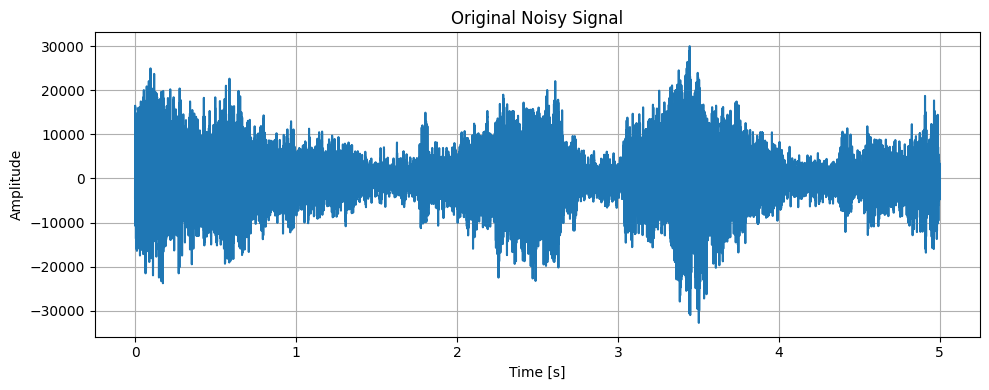

In [4]:
plot_signal(noisy_signal, fs, title='Original Noisy Signal')

In [42]:
output_path = 'low_pass_denoised_seg_101.wav'
denoise_audio_lowpass(input_path, output_path, 1000)

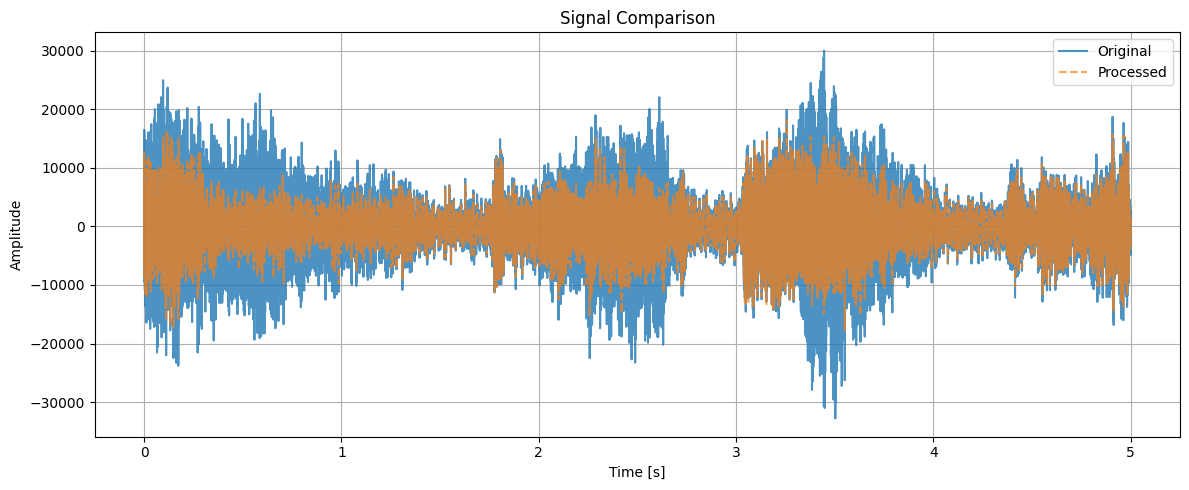

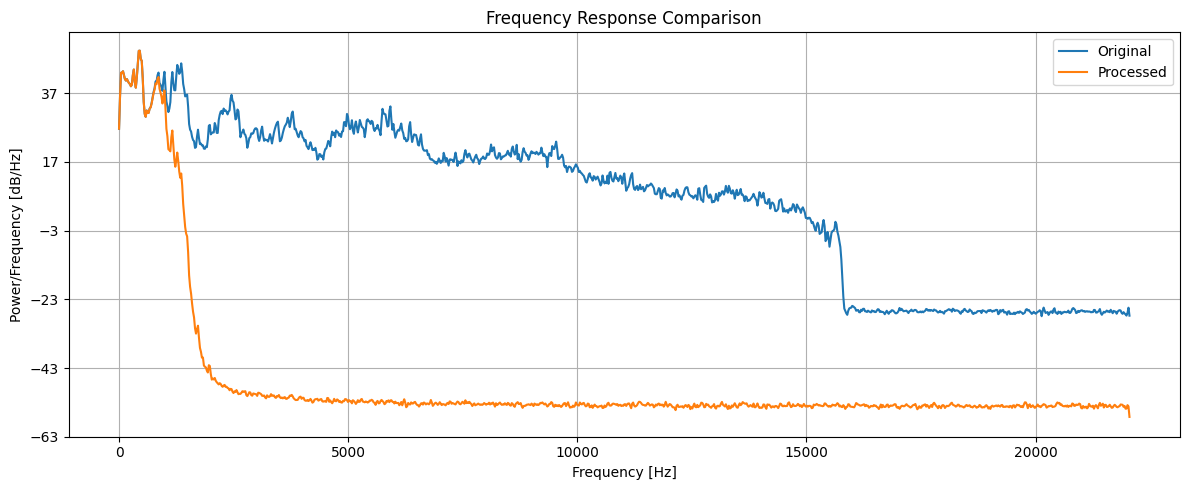

In [43]:
fs1, noisy_signal = load_wav(input_path)
fs2, denoised_signal = load_wav(output_path)

plot_signals(noisy_signal, fs1, denoised_signal, fs2, labels=('Original', 'Processed'))
plot_frequency_response(noisy_signal, fs1, denoised_signal, fs2, labels=('Original', 'Processed'))

In [7]:
output_path = 'high_pass_denoised_seg_101.wav'
denoise_audio_highpass(input_path, output_path, 3000)

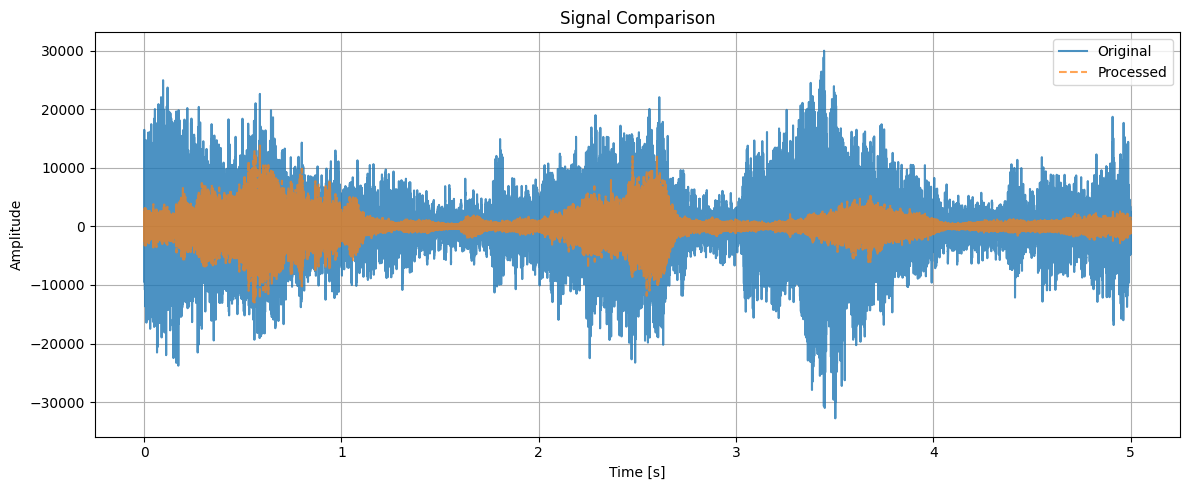

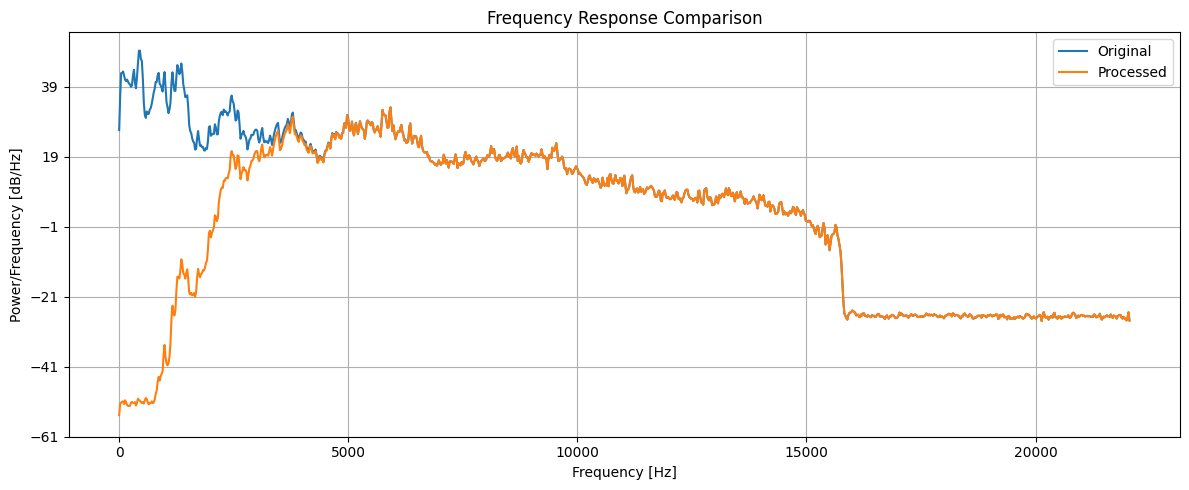

In [8]:
fs1, noisy_signal = load_wav(input_path)
fs2, denoised_signal = load_wav(output_path)

plot_signals(noisy_signal, fs1, denoised_signal, fs2, labels=('Original', 'Processed'))
plot_frequency_response(noisy_signal, fs1, denoised_signal, fs2, labels=('Original', 'Processed'))

In [21]:
import numpy as np
from scipy import signal
from src.utils import load_wav, save_wav

def design_iir_bandstop(input_path, output_path, bands, order=2, filter_type='butter'):
    """
    Apply multiple band-stop IIR filters to an audio file.

    Args:
        input_path: Path to the noisy wav file
        output_path: Where to save the denoised wav file
        bands: List of (lowcut, highcut) frequency tuples (in Hz) to remove
        order: Filter order (default 2)
        filter_type: 'butter' or 'cheby1'
    """
    fs, data = load_wav(input_path)

    # Normalize if integer audio
    if data.dtype.kind == 'i':
        data = data.astype(np.float32) / np.iinfo(data.dtype).max

    nyq = 0.5 * fs

    # Process stereo or mono
    if data.ndim == 2:  # Stereo
        data_denoised = np.copy(data)
        for ch in range(data.shape[1]):
            for band in bands:
                low = band[0] / nyq
                high = band[1] / nyq
                if filter_type == 'butter':
                    sos = signal.butter(order, [low, high], btype='bandstop', output='sos')
                elif filter_type == 'cheby1':
                    sos = signal.cheby1(order, 1, [low, high], btype='bandstop', output='sos')
                else:
                    raise ValueError(f"Unsupported filter type: {filter_type}")
                data_denoised[:, ch] = signal.sosfiltfilt(sos, data_denoised[:, ch])
    else:  # Mono
        data_denoised = np.copy(data)
        for band in bands:
            low = band[0] / nyq
            high = band[1] / nyq
            if filter_type == 'butter':
                sos = signal.butter(order, [low, high], btype='bandstop', output='sos')
            elif filter_type == 'cheby1':
                sos = signal.cheby1(order, 1, [low, high], btype='bandstop', output='sos')
            else:
                raise ValueError(f"Unsupported filter type: {filter_type}")
            data_denoised = signal.sosfiltfilt(sos, data_denoised)

    # Save
    save_wav(output_path, fs, data_denoised)



In [28]:
# input_path = 'seg_101.wav'
# fs, noisy_signal = load_wav(input_path)
output_path = 'bandstop_denoised_seg_101.wav'

# Define noise bands you want to remove
bands_to_remove = [
    # (48, 52),
    # (438, 440),
    (446, 448)
]

# denoise_audio_multibandstop(input_path, output_path, bands=bands_to_remove, order=4)
design_iir_bandstop(input_path, output_path, bands=bands_to_remove)

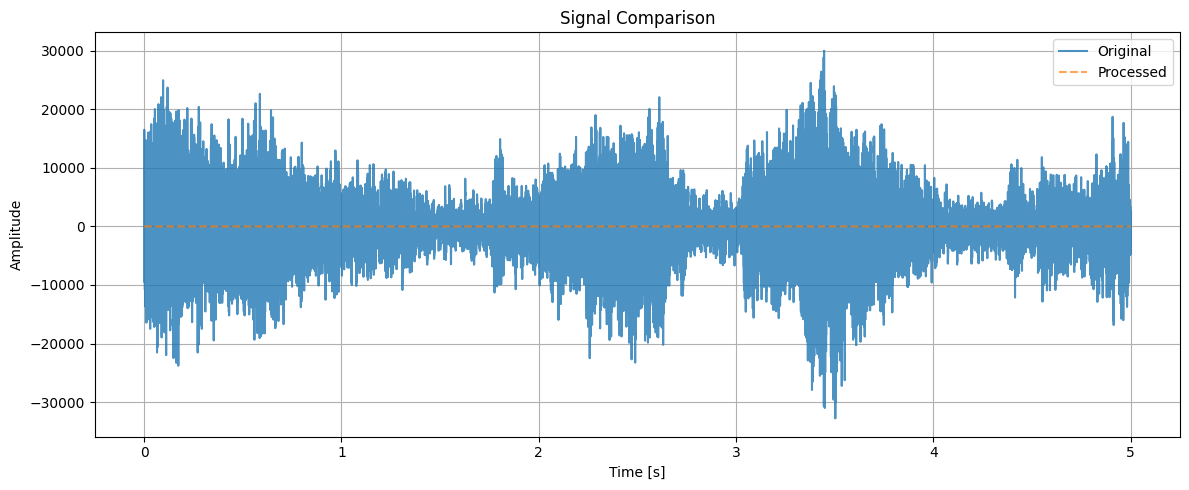

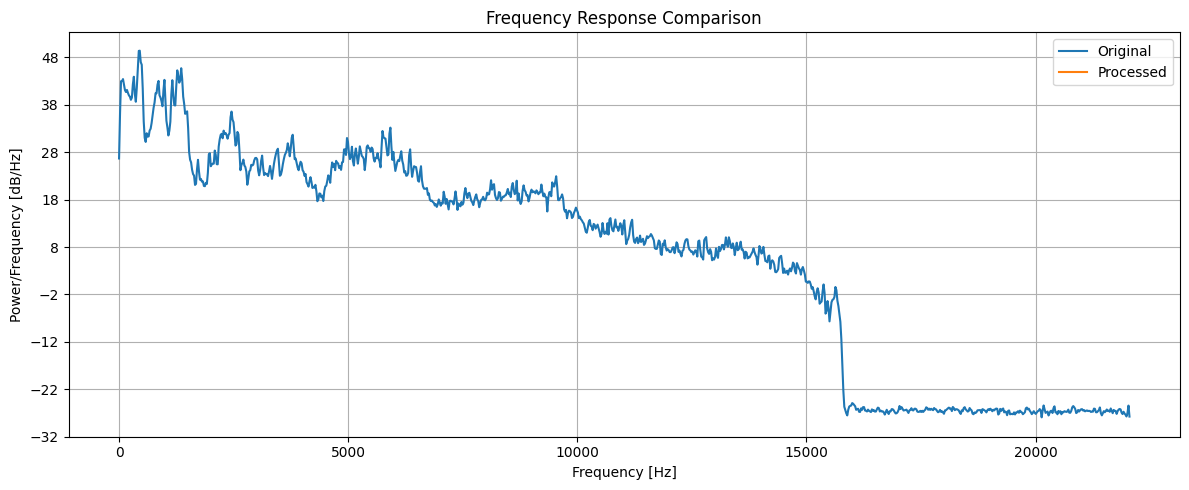

In [29]:
fs1, noisy_signal = load_wav(input_path)
fs2, denoised_signal = load_wav(output_path)

plot_signals(noisy_signal, fs1, denoised_signal, fs2, labels=('Original', 'Processed'))
plot_frequency_response(noisy_signal, fs1, denoised_signal, fs2, labels=('Original', 'Processed'))